# CPIC图像仿真程序运行说明

程序中提供了两种仿真程序调用方式。一种为命令行调用，一种为程序调用。


## 命令行调用
当程序完成安装，并且设置环境变量后，可以通过命令行的方法进行调用。

下面是一个简单的示例代码：
```powershell
cpic_sim quickrun '*0/15(0.4,0.6)' 10 50 6
```
表示对于0等星附近(0.4as, 0.6as)处15等的行星，单帧曝光10s，em倍增50倍，共6帧。

运行该指令，可以看到在当前目录下生成一个名为"0/15(0.4,0.6).fits"的文件，为仿真生成的图像。

运行以下命令查看帮助
```powershell
cpic_sim quickrun -h
```




## 快速调用
快速仿真使用`quick_run`函数，该函数的参数如下：
- target_str: 观测目标字符串
- band: 观测波段
- expt: 单帧图像曝光时间秒数
- emgain: 倍增增益/倍增增益设置值
- nframe: 仿真图像帧数
- skymag: 天空背景星等，可选，默认无背景
- rotation: 图像焦面旋转角度，可选，默认无旋转
- shift: 图像中心偏移量
- emset_input: emgain为倍增增益还是倍增设置值，可选，默认倍增增益
- cr_frame, 控制宇宙线输入，可选，默认无宇宙线
- camera_effect: 是否包含相机效应，可选，默认无相机效应
- prograss_bar: 是否显示进度条，可选，默认不显示
- output: 输出图像路径，可选，默认为当前文件夹

这里重点说明一下`target_str`的详细说明，该字符串可以选择输入yaml文件和格式字符串。
格式化字符串示例如下：

*star0_magnitude/star1_magnitude(star1_x,star1_y)/star2_magnitude(star2_x,star2_y)

表示目标为三颗恒星，中央恒星星等为star0_magnitude，其余两颗恒星星等为star1_magnitude和star2_magnitude，位置分别为(star2_x,star2_y)和(star1_x,star1_y)。所有的星等都为标准的ab星等的参考光谱。

当该字符存为空时，则没有输入目标，可以进行暗场或者平场模拟。

仿真程序输出为3D的numpy.Array图像。同时文件将存储在output文件夹下

下面的代码为一个例子。

Quick Run: *0/15(0.4,0.6)
 Simulation Running: Frame 6/6./0_15(0.4_0.6)_20240515113846.fits
  Done [16.6s]                             


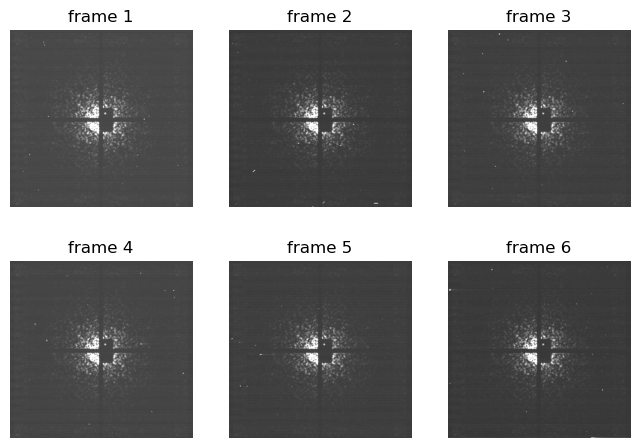

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from csst_cpic_sim import quick_run_v2
from csst_cpic_sim.utils import psf_imshow

def psf_imshow(psf, vmin=1e-8, vmax=0.1):
    focal_img = psf.copy()
    focal_img = np.maximum(focal_img, vmin)
    focal_img = np.minimum(focal_img, focal_img.max()*vmax)
    image_log = np.log10(focal_img)
    plt.imshow(image_log, origin='lower', cmap='gray')

images = quick_run_v2(
    '*0/15(0.4,0.6)',
    'f661',
    10,
    50,
    6,
    skybg=20,
)

fig = plt.figure(figsize=(8, 5.5))
for index in range(6):
    plt.subplot(2, 3, index+1)
    psf_imshow(images[index])
    plt.axis('off')
    plt.title(f'frame {index+1}')

可以使用`observation_simulation`函数对仿真进行更详细的定制。
该函数包括如下参数：

- target: 目标字典
- skybg: 背景光强度
- expt: 曝光时间
- nframe: 拍摄帧数
- band: 观测波段
- emgain: 电子倍增
- obsid: 观测ID
- rotation: 旋转角度
- shift: 图像偏移
- gnc_info: 导航制导信息
- csst_format: 是否使用CSST标准格式
- psf_function: PSF生成函数

其中目标字典对观测目标进行配置，详见观测目标仿真文档。obsid为观测ID，和未来观测时的指令对应。一个观测ID对应一组图像，这些图像曝光时间等其他仪器设置、观测目标均相同。观测ID第一位固定为5，第二三位对应不同的观测类型。详见0级数据说明。gnc_info定义了曝光开始时刻与结束时刻是望远镜的定位信息，写入头文件。csst_format为True时，使用0级数据定义的数据格式存储数据。psf_function为PSF生成函数，可使用main模块中的psf_function函数，也可以根据需求进行自定义，详见focus模块注释。

下面是一个例子。

Simulation Running: Frame 1/6
Simulation Running: Frame 2/6
Simulation Running: Frame 3/6
Simulation Running: Frame 4/6
Simulation Running: Frame 5/6
Simulation Running: Frame 6/6


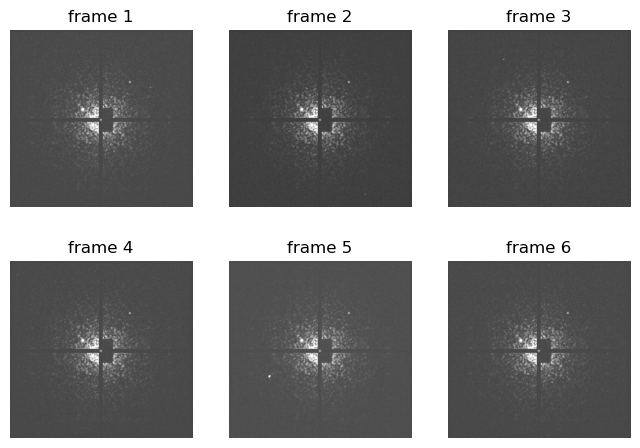

In [37]:
#io
target = {
    'name': 'TEST1',
    'cstar': {
        'magnitude': 0,
        'ra': '120d',
        'dec': '40d',
        'distance': 10,
        'sptype': 'G0III',
    },
    'stars': [
        {
            'magnitude': 15,
            'ra': '120.001d',
            'dec': '40.001d',
            'sptype': 'F0III',
            'isblackbody': True
        },
        {
            'magnitude': 10,
            'pangle': -60,
            'separation': 2,
            'sptype': 'A2.5II',
            'isblackbody': False
        },

    ],
    'planets': [
        {
            'radius': 2,
            'pangle': 60,
            'coe_b': 0.3,
            'coe_r': 0.7,
            'separation': 0.5,
            'phase_angle': 90,
        }
    ]
}

from CpicImgSim import observation_simulation
images = observation_simulation(target, 21, 1, 6, 'f661', 50, obsid=51900000000)

fig = plt.figure(figsize=(8, 5.5))
for index in range(6):
    plt.subplot(2, 3, index+1)
    psf_imshow(images[index])
    plt.axis('off')
    plt.title(f'frame {index+1}')

### 附录

gnc_info定义了望远镜的位置、速度及姿态信息。仿真程序中不依赖这些值，仅将其按照特定格式写入fits文件中。gnc数据结构为python字典，包括如下键值：

- `EXPSTART`: 曝光开始时刻，默认为程序执行时刻
- `EXPEND` : 曝光结束时刻，默认为程序执行时刻+图像曝光时间的和
- `CABSTART` : 开始时段望远镜位置信息采集时刻，MJD格式，默认和EXPSTART相同
- `SUNANGL0` ：CABSTART时刻视轴与太阳的夹角，默认为-1.0
- `MOONANG0` ：CABSTART时刻视轴与月球的夹角，默认为-1.0
- `TEL_ALT0` : CABSTART时刻视轴与地平的夹角，默认为-1.0
- `POS_ANG0` ：CABSTART时刻方位角，默认为rotation
- `POSI0_X` ：CABSTART时刻望远镜X位置，默认为-1.0
- `POSI0_Y` ：CABSTART时刻望远镜Y位置，默认为-1.0
- `POSI0_Z` ：CABSTART时刻望远镜Z位置，默认为-1.0
- `VELO0_X` ：CABSTART时刻望远镜X速度，默认为-1.0
- `VELO0_Y` ：CABSTART时刻望远镜Y速度，默认为-1.0
- `VELO0_Z` ：CABSTART时刻望远镜Z速度，默认为-1.0
- `EULER0_2` ：CABSTART时刻望远镜欧拉角2，默认为-1.0
- `EULER0_3` ：CABSTART时刻望远镜欧拉角3，默认为-1.0
- `EULER0_1` ：CABSTART时刻望远镜欧拉角1，默认为-1.0
- `RA_PNT0` ：CABSTART时刻视轴RA，默认为cstar的ra
- `DEC_PNT0` ：CABSTART时刻视轴Dec，默认为cstar的DEC
- `CABEND` : 结束时段位置信息采集时刻，默认为EXPEND+曝光时间
- `SUNANGL1` : CABEND时刻视轴与太阳的夹角，默认等于CABEND时刻的对应值
- `MOONANG1` : CABEND时刻视轴与月球的夹角，默认等于CABEND时刻的对应值
- `TEL_ALT1` : CABEND时刻视轴与地平的夹角，默认等于CABEND时刻的对应值
- `POS_ANG1` : CABEND时刻方位角，默认等于CABEND时刻的对应值
- `POSI1_X` : CABEND时刻望远镜X位置，默认等于CABEND时刻的对应值
- `POSI1_Y` : CABEND时刻望远镜Y位置，默认等于CABEND时刻的对应值
- `POSI1_Z` : CABEND时刻望远镜Z位置，默认等于CABEND时刻的对应值
- `VELO1_X` : CABEND时刻望远镜X速度，默认等于CABEND时刻的对应值
- `VELO1_Y` : CABEND时刻望远镜Y速度，默认等于CABEND时刻的对应值
- `VELO1_Z` : CABEND时刻望远镜Z速度，默认等于CABEND时刻的对应值
- `EULER1_1` : CABEND时刻望远镜欧拉角2，默认等于CABEND时刻的对应值
- `EULER1_2` : CABEND时刻望远镜欧拉角3，默认等于CABEND时刻的对应值
- `EULER1_3` : CABEND时刻望远镜欧拉角1，默认等于CABEND时刻的对应值
- `RA_PNT1` : CABEND时刻视轴RA，默认等于CABEND时刻的对应值
- `DEC_PNT1` : CABEND时刻视轴Dec，默认等于CABEND时刻的对应值